# Time Series Project -- Blind Denoising with Random Greedy Pursuits

**Authors:** Mathis Clautrier and Victor Letzelter

*NB: This code allows to reproduce the results presented in the report. For all details, please refer to this one. For reproducing the results of the report, the execution of part V. and VI. is computationnaly costly. Therefore, we adapted the notebook so that it is executable from Google Colab without running the parts V. and VI. (the outputs are imported automatically from dropbox files).*

---

#I. Setup 

Installation of the required libraries

In [1]:
!pip install ruptures
!pip install dtw
!pip install dtw-python

     |████████████████████████████████| 991 kB 5.1 MB/s 
  Created wheel for dtw: filename=dtw-1.4.0-py3-none-any.whl size=5315 sha256=b7206f3df160b2fdc9d461ff8e1885db93fbcfa975d76a0ccaf0045c19b4f495
  Stored in directory: /root/.cache/pip/wheels/f9/51/54/b7f446e6d4f5be9a66066b59c5030731191260515737be4496
Successfully built dtw
     |████████████████████████████████| 580 kB 4.3 MB/s 


Imports of the libraries 

In [2]:
import pywt
import datetime as dt
import scipy
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import log
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ruptures as rpt
from matplotlib.dates import DateFormatter
from ruptures.base import BaseCost
from ruptures.metrics import hausdorff
from scipy.stats import ttest_ind
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import acf, adfuller, kpss, pacf
from scipy.special import erfinv
import gc
from dtw import *

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



Importation of the original dataset 

In [3]:
!wget https://www.dropbox.com/s/87lorwjyi8lzljh/electric_production.csv?dl=0 -O /content/electric_production.csv

--2022-03-23 19:42:53--  https://www.dropbox.com/s/87lorwjyi8lzljh/electric_production.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/87lorwjyi8lzljh/electric_production.csv [following]
--2022-03-23 19:42:53--  https://www.dropbox.com/s/raw/87lorwjyi8lzljh/electric_production.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7b07ee863b0c4863ecd06f83e8.dl.dropboxusercontent.com/cd/0/inline/BiBDotjUWyd-WTTEJj4HLNJqR-jnYra8ZFsrqS1CD841Tx0iULNRroUbexpWYPTuoWJjmdxkiEI-4aqw_v75fNdEUIq8vPypugbBRcX6PtObFnkG80aBHrizDDsSoagyL-rtaEClOIfYbBUar99_ZQ30WXLHlHoThCk9rYaNMvHy_w/file# [following]
--2022-03-23 19:42:53--  https://uc7b07ee863b0c4863ecd06f83e8.dl.dropboxusercontent.com/cd/0/inline/BiBDotjUWyd-WTTEJj4HLNJqR-jnYr

Useful functions

In [4]:
def firsts(l) : #Function that returns the first elements given a tuple of tuples.
  return [e[0] for e in l]

def seconds(l) : #Function that returns the second elements given a tuple of tuples.
  return [e[1] for e in l]

def rmse(predictions, targets): #RMSE function
    return np.sqrt(((predictions - targets) ** 2).mean())

# II. Data management and visualisation

Study of the caracteristics of the dataset

Dataset visualisation

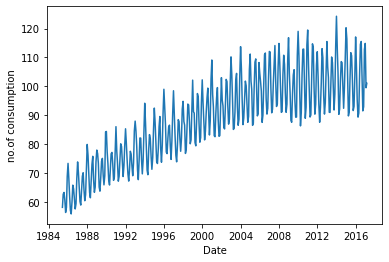

In [5]:
df = pd.read_csv("electric_production.csv")
df['DATE']= pd.to_datetime(df['DATE'], infer_datetime_format=True)
df=df.set_index(['DATE'])

plt.xlabel('Date')
plt.ylabel('no.of consumption')
plt.plot(df)

In [6]:
def plot_clinear_approx(time_index, signal, bkps, ax=None):
    # plot
    ax.plot(time_index, signal)
    # plot changes
    for b in bkps[:-1]:
        ax.axvline(time_index[b], ls="--", color="k")
    # add linear approximation
    indexes = np.r_[0, np.array(bkps) - 1]
    ax.plot(
        np.take(time_index, indexes),
        np.take(signal, indexes),
        color="k",
        alpha=0.5,
    )
    ax.scatter(
        np.take(time_index, indexes),
        np.take(signal, indexes),
        color="r",
        alpha=0.5,
        s=100,
        marker="*",
    )
    ax.margins(x=0)

Detection of breaking points in the 

In [7]:
def fig_ax(nrows=1, figsize=(15, 3)):
    return plt.subplots(nrows=nrows, figsize=(figsize[0], figsize[1] * nrows))

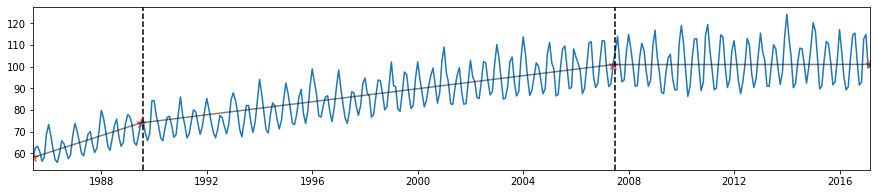

In [8]:
K_max = 15

index = df.index
signal = df['Value'].values
def pen_clinear(signal: np.ndarray, pen: float)->list:
    n_samples = signal.shape[0]
    algo = rpt.Dynp(model="clinear", jump=5).fit(signal)
    algo.predict(n_bkps=K_max)
    list_of_v = [algo.cost.sum_of_costs([n_samples])]
    for n_bkps in range(1, K_max):
        bkps = algo.predict(n_bkps=n_bkps)
        list_of_v.append(algo.cost.sum_of_costs(bkps) + pen * n_bkps)
    
    n_bkps_opt = np.argmin(list_of_v)
    if n_bkps_opt==0:
        return [n_samples]
    else:
        return algo.predict(n_bkps=n_bkps_opt)

pen_bic = 2 * signal[:50].var() * log(signal.shape[0])
detected_bkps = pen_clinear(signal=signal, pen=pen_bic)

fig, ax = fig_ax()
plot_clinear_approx(time_index=index, signal=signal, bkps=detected_bkps, ax=ax)

In [9]:
new_feature = []
t0 = 0
t1 = 0
for i in range(len(detected_bkps)):
  t1 = detected_bkps[i]
  Y = signal[t0:t1]
  X = np.arange(len(Y)).reshape(-1,1)
  reg = LinearRegression().fit(X, Y )
  print(i,reg.coef_,reg.intercept_)
  new_feature.append(Y - reg.predict(X))
  t0 = detected_bkps[i]
signal_without_linear_trend = np.concatenate(new_feature)

0 [0.22634225] 60.55112094117648
1 [0.14074782] 71.78772607235142
2 [0.01690748] 101.06619238012458


Signal without linear trend

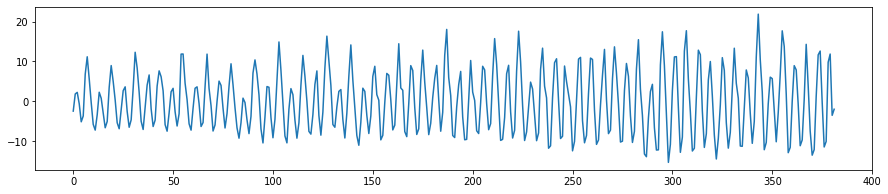

In [10]:
fig,ax = fig_ax()
ax.plot(signal_without_linear_trend)
df['w/o_trend'] = signal_without_linear_trend

Dickey-Fuller Test to evaluate the stationnarity of the signal 

In [11]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [12]:
adf_test(df.Value)

Results of Dickey-Fuller Test:
Test Statistic                  -2.595353
p-value                          0.093962
#Lags Used                      15.000000
Number of Observations Used    366.000000
Critical Value (1%)             -3.448344
Critical Value (5%)             -2.869469
Critical Value (10%)            -2.570994
dtype: float64


In [13]:
adf_test(df['w/o_trend'])

Results of Dickey-Fuller Test:
Test Statistic                -6.023278e+00
p-value                        1.476252e-07
#Lags Used                     1.400000e+01
Number of Observations Used    3.670000e+02
Critical Value (1%)           -3.448294e+00
Critical Value (5%)           -2.869448e+00
Critical Value (10%)          -2.570983e+00
dtype: float64


ACF and PACF functions of the original signal

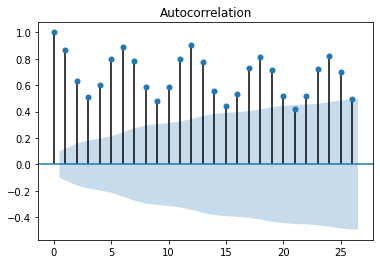

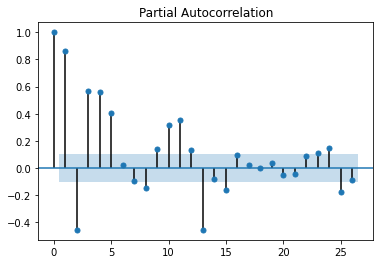

In [14]:
_ = plot_acf(df.Value)
_ = plot_pacf(df.Value)

ACF and PACF function of the detrended signal 

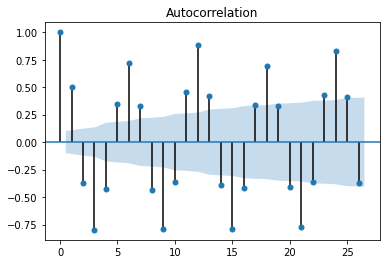

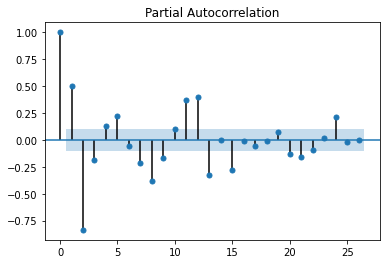

In [15]:
_ = plot_acf(df['w/o_trend'])
_ = plot_pacf(df['w/o_trend'])

Periodigram of the signal

The main periods are 6.0 months and 11.9 months.


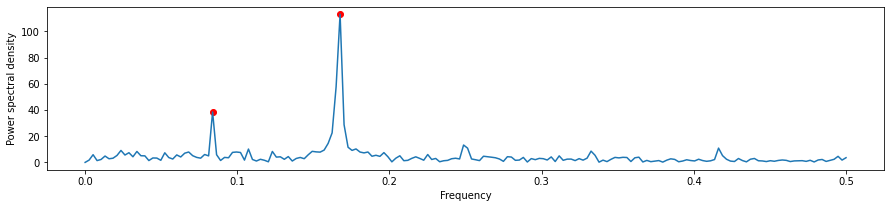

In [16]:
from scipy.signal import periodogram,argrelmax

def get_largest_local_max(
    signal1D: np.ndarray, n_largest: int = 3, order: int = 1
) -> [np.ndarray, np.ndarray]:
    """Return the largest local max and the associated index in a tuple.

    This function uses `order` points on each side to use for the comparison.
    """
    all_local_max_indexes = argrelmax(signal1D, order=order)[0]
    all_local_max = np.take(signal1D, all_local_max_indexes)
    largest_local_max_indexes = all_local_max_indexes[
        all_local_max.argsort()[::-1]
    ][:n_largest]

    return (
        np.take(signal1D, largest_local_max_indexes),
        largest_local_max_indexes,
    )

# compute the periodogram
freqs, Pxx_spec = periodogram(
    x=df['w/o_trend'],
)
spectral_density = np.sqrt(Pxx_spec)

values, (f_1_ind, f_2_ind) = get_largest_local_max(
    spectral_density, n_largest=2
)
(f_1, f_2) = np.take(freqs, (f_1_ind, f_2_ind))

print(
    f"The main periods are {1/f_1:.1f} month{'s' if 1/f_1>1 else ''} and {1/f_2:.1f} month{'s' if 1/f_2>1 else ''}."
)

# plotting
fig, ax = fig_ax()
ax.plot(freqs, spectral_density)
ax.set_xlabel("Frequency")
ax.scatter([f_1, f_2], values, color="r")
_ = ax.set_ylabel("Power spectral density")

Construction of a smoother versoin of the signal using a moving average

In [17]:
def moving_average(signal,T):
    N_signal=len(signal)
    ma = []
    for i in range(N_signal-T):
        ma.append(np.mean(signal[i:i+T]))
    return ma

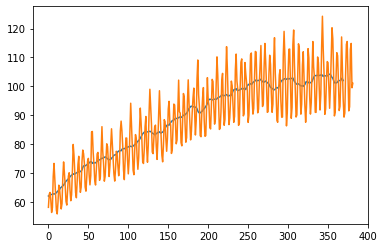

In [18]:
T=12
ma=moving_average(signal,T)
plt.plot(ma)
plt.plot(signal)

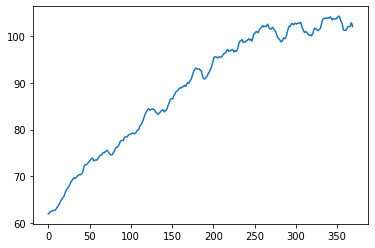

In [19]:
signal = ma
plt.plot(signal)

In [20]:
np.save('signal.npy',signal) #We save the signal on which we will work

#III. State of the art denoising algorithms implementation

BIRD algorithm

In [21]:
def BIRD(f,D,p,subsize,iter_max= 10):
    """
    BIRD algorithm (see https://arxiv.org/abs/1312.5444)
    Inputs:
      - f: signal to be denoised
      - D: dictionnary matrix of size (N_signal,N_atoms)
      - p: parameter in the stopping condition.
      - subsize: size of the subdictionnaries used at each iterations
      - iter_max: maximum number of iterations of the algorithm.
    Output:
      - a: Activation vector of size (N_atoms).
    """ 
    N_signal,N_atoms = D.shape
    D = D/np.linalg.norm(D, axis=0) #The dictionnary is normalized. 
    a = np.zeros(N_atoms)
    r = f.copy() #Will contain the residual vector. 
    cond = np.sqrt(2)/N_signal*np.sqrt(1 - 2/np.pi)*erfinv((1-p)**(1/N_atoms)) #$\Lambda_{W}(\Phi, p)$ in the paper. 
    residual_norm_cur = 0
    residual_norm_previous = 1
    index = list(np.arange(N_atoms))
    for t in range(iter_max):
        selected_index = np.array(random.sample(index,subsize))
        subdic = D[:,selected_index] #Subdictionnary selected. 
        product = np.dot(subdic.T,r) #Scalar product between the current residual and the elements of the dictionnary. 
        i = np.argmax(np.abs(product))
        a[selected_index[i]] += product[i] #Update of the activation vector
        r = r -  product[i] * subdic[:,i] #Update of the residual. 
        residual_norm_cur = np.linalg.norm(r)
        rapport = residual_norm_cur/residual_norm_previous
        lambda_cond = np.sqrt(1 - rapport**2) #$\lambda_{\Phi}(y)$
        if lambda_cond <= cond: #Stopping condition reached
            if t==0:
                continue
            else:
                break  
        residual_norm_previous = residual_norm_cur 
    del selected_index
    del r
    del product
    del subdic
    gc.collect()
    print(str(t) + str("-"),end = '')  
    return a

Random matching pursuit algorithm

In [22]:
def random_matching_pursuit(f,D,subsize,iter,iter_max= 10, target_d = None, original = None):
    """
    Random matching pursuit algorithm with stochastic selection (see https://hal.archives-ouvertes.fr/hal-00725075/document).
    Inputs:
      - f: signal to be denoised
      - D: dictionnary matrix of size (N_signal,N_atoms)
      - subsize: size of the subdictionnaries used at each iterations
      - iter: if iter=0, the whole dictionnary is selected, otherwise we select a subset of it. 
      - iter_max: maximum number of iterations. 
      - target_d: targeted distance with the original signal (optionnal)
      - original: orignal signal (optionnal)
    Output: 
      - a: Activation vector of size (N_atoms).
    """
    N_signal,N_atoms = D.shape 
    D = D/np.linalg.norm(D, axis=0) #The dictionnary is normalized. 
    a = np.zeros(N_atoms)
    T1,T2 = 15,15 #To avoid edge effects when calculating the DTW distance with the original signal (useless parameters when target_d=None) 
    r = f.copy()
    if iter == 0:
      subdic = D
      selected_index = list(np.arange(N_atoms))
    else:
      index = list(np.arange(N_atoms))
      selected_index = np.array(random.sample(index,subsize))
      subdic = D[:,selected_index]
    for t in range(iter_max):
        product = np.dot(subdic.T,r)
        i = np.argmax(np.abs(product))
        a[selected_index[i]] += product[i]
        r = r -  product[i] * subdic[:,i]
        ftild = np.dot(D,a)
        if target_d is not None:
            d= dtw(ftild[T1:-T2],original[T1:-T2]).distance
            if d < target_d:
                break
    del selected_index
    del r
    del product
    del subdic
    gc.collect()
    print(str(t) + str("-"),end = '')  
    return a 

Matching pursuit algorithm

In [23]:
def matching_pursuit(f,D,iter_max= 10, target_d = None, original = None):
    """
    Original matching pursuit algorithm (see https://www.researchgate.net/publication/3315110_Matching_Pursuit_with_Time-Frequency_Dictionaries)
    Inputs:
      - f: signal to be denoised
      - D: dictionnary matrix of size (N_signal,N_atoms)
      - iter_max: maximum number of iterations. 
      - target_d: targeted distance with the original signal (optionnal)
      - original: orignal signal (optionnal)
    Output: 
      - a: Activation vector of size (N_atoms).
    """
    N_signal,N_atoms = D.shape
    T1,T2 = 15,15
    D = D/np.linalg.norm(D, axis=0)
    a = np.zeros(N_atoms)
    r = f.copy()    
    norms = np.zeros(iter_max)
    for t in range(iter_max):
        product = np.dot(D.T,r)
        i = np.argmax(np.abs(product))
        norms[t] = np.linalg.norm(r)
        a[i] += product[i]
        ftild = np.dot(D,a)
        r = r -  product[i] * D[:,i]
        if target_d is not None :
            d= dtw(ftild[T1:-T2],original[T1:-T2]).distance
            if d <target_d:
                break
    del r
    del product
    print(t) #We print the number of iterations. 
    return a

Random orthogonal matching pursuit algorithm

In [24]:
def random_orthogonal_matching_pursuit(f,D,c2,sigma2,iter_max= 10, target_d = None, original = None):
    """
    Orthogonal matching pursuit algorithm (see https://ieeexplore.ieee.org/document/5238753).
    Inputs:
      - f: signal to be denoised
      - D: dictionnary matrix of size (N_signal,N_atoms)
      - c2: see the paper, corresponds to $c^{2}=\frac{\sigma_{x}^{2}}{\sigma_{x}^{2}+\sigma^{2}}$ 
      where $\sigma_{x}^{2}$ s the variance of the nonzero entries of the representa- tion of the original signal
      and $\sigma^{2}$ is the std of the noise
      - sigma2: assumed variance value for the noise. 
      - iter_max: maximum number of iterations. 
      - target_d: targeted distance with the original signal (optional)
      - original: orignal signal (mandatory only is target_d is not None)
    Output: 
      - a: Activation vector of size (N_atoms).
    """
    N_signal,N_atoms = D.shape
    T1,T2 = 15,15
    D = D/np.linalg.norm(D, axis=0)
    r = f.copy()
    x = np.zeros(N_atoms)
    indexes = set()
    for t in range(iter_max):
        if t%100 == 0 and t>0:
            print('*',end='')
        product = np.dot(D.T,r)
        projected_product = product.copy()
        log_prob = c2*(projected_product**2)/(2*sigma2)*(x== 0)
        g = -np.log(-np.log(np.random.random(N_atoms)))*(x==0)
        new_index = np.argmax(g+log_prob) #Use of the Gambel trick. 
        indexes.add(new_index)
        projectedD = D[:,list(indexes)]
        x[list(indexes)] = np.linalg.pinv(projectedD) @ f      
        ftild = np.dot(D,x)
        r = f -  ftild
        if target_d is not None:
            d= dtw(ftild[T1:-T2],original[T1:-T2]).distance
            if d <target_d:
                break
    del projected_product
    del log_prob
    del g
    del product
    del projectedD
    del r
    del ftild
    del indexes
    gc.collect()
    print(str(t) + str("-"),end = '')    
    return x

Shrinkage algorithm with Debauchies wavelets

In [25]:
def wavelet_denoising(f, wavelet='db4', level=1,mode_threshold='hard',n=1) :
    """
    Shrinkage algorithm using wavelets (see https://www.itl.waw.pl/czasopisma/JTIT/2005/3/91.pdf)
    Inputs:
      - f: signal to be denoised.
      - wavelet: type of wavelet to use (See pywt.families(short=False) for the possible families, and for a given family (e.g 'db'), 
      see pywt.wavelist(kind='db') for the wavelets of the family)
      - level: level of the discrete wavelet transform (DWT) to consider (see https://en.wikipedia.org/wiki/Discrete_wavelet_transform)
      - mode_threshold: thresholding mode ('soft' or 'hard')
      - n: parameter to consider when using the std approach for denoising.
    Output:
      - Denoised signal, reconstructed using inverse wavelet transform. 
    """
    coefficients = pywt.wavedec(f, wavelet, mode="per")
    sigma = np.std(coefficients[-level])
    thresh = sigma*n
    coefficients[1:] = (pywt.threshold(i, value=thresh, mode=mode_threshold) for i in coefficients[1:])
    return pywt.waverec(coefficients, wavelet, mode='per')

Construction of the MCDT dictionnary

In [26]:
def MDCT(L,k,N,start):
    """
    MDCT of window functions dictionnary (Modified discrete cosine transform, see https://en.wikipedia.org/wiki/Modified_discrete_cosine_transform)
    Inputs:
      - L: is such that the input vector has 2L components. 
      - k: Index of the transformed vector.
      - N: Output vector size. 
      - starting position index in the output vector. 
    Output:
      -
    """
    u = np.linspace(0,2*L-1,2*L) #Steps considered.
    w = np.sin(np.pi*(u+.5)/(2*L)) #(Symmetric) Window function to be transformed. 
    MDCT = w*np.cos(np.pi*(2*u+L+1)*(2*k+1)/(4*L))*np.sqrt(2/L)
    S = np.zeros(N)
    S[start:start+2*L] = MDCT
    return S

In [27]:
LS=[32, 64, 128] #We get the number of elements of the dictionnary 
n = 0
for L in LS:
    for k in range(L):
        for s in range(len(signal) - 2*L) :
            n+=1

In [28]:
DICO = np.zeros((len(signal),n)) #We construct the dictionnary. 
col = 0
length_signal = len(signal)
for L in LS:
    for k in range(L):
        r = int(length_signal/L/2)
        for s in range(length_signal - 2*L):
            DICO[:,col] = MDCT(L,k,length_signal,s)
            col+=1

Test of the BIRD algorithm

In [29]:
params={"f" : signal,"D" : DICO,"p":1e-10,"subsize":DICO.shape[1]//50,"iter_max" :2000}

In [30]:
activation = np.zeros(DICO.shape[1])
J = 5
for j in range(J):
  activation += BIRD(**params)
activation = activation/J

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in sqrt


607-512-616-483-621-

1088.3967013384013


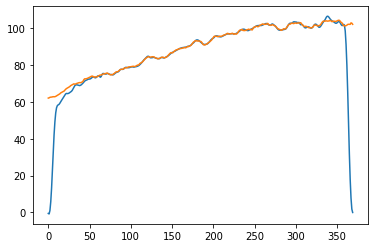

In [31]:
plt.plot(DICO @ activation)
plt.plot(signal)
alignement = dtw(DICO @ activation,signal)
print(alignement.distance)

We notice the edge effects. For the next DTW calculations, two parameters $T_{1}$ and $T_{2}$ will be added to restrict the calculation to (DICO @ activation)[T1:-T2] and signal[T1:-T2].

#IV. Generation of the noise and hypothesis checking

Function to generate the noise

In [32]:
def color_noise_gen(shape,pourcent,maxvalue,alpha,gap):
    DFTC = np.array([(gap*f + gap)**(-alpha) for f in range(shape)])
    DFTY = np.fft.fft(np.random.normal(size = shape))
    noise = np.fft.ifft(np.sqrt(DFTC)*DFTY)
    noise = noise.real
    noise -= noise.mean()
    maxnoise = np.quantile(np.abs(noise),.9)
    scale = pourcent*maxvalue/maxnoise
    return scale*noise

For each of the color noises considered, let us check if the distribution of the projection of the color noises on the atoms follow a Gaussian distribution. 

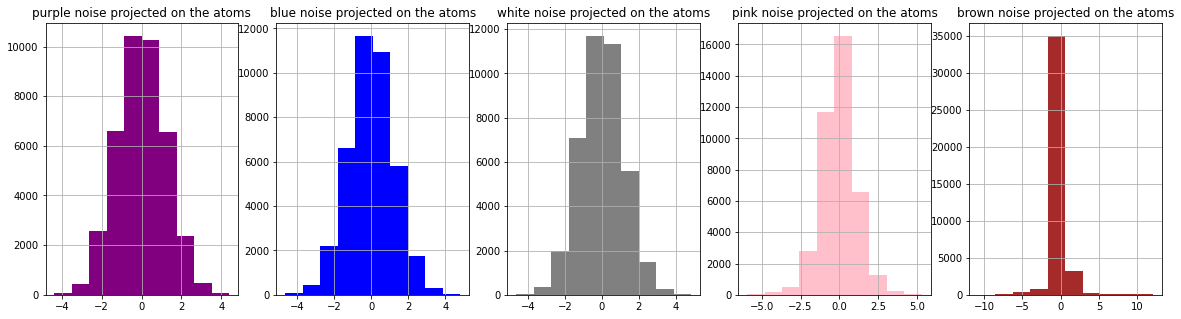

In [33]:
#Let us check is the distribution of the noise on the atoms is gaussian
signal=np.load('/content/signal.npy')
colors=['purple','blue','white','pink','brown']
alpha=-2

fig,ax=plt.subplots(1,len(colors),figsize=(20,5))

for color in colors :

    color_noise = color_noise_gen(370,.05,40,alpha,0.001)
    product = np.dot(DICO.T,color_noise)
    if color!='white' :
        ax[alpha+2].hist(product,color=color)
    if color=='white' : #To make the histogram visible
        ax[alpha+2].hist(product,color='grey')
    ax[alpha+2].set_title('{} noise projected on the atoms'.format(color))
    ax[alpha+2].grid()
    alpha+=1

We can otherwise check that the informative part of the signal has a (much) heavier tail than the noise

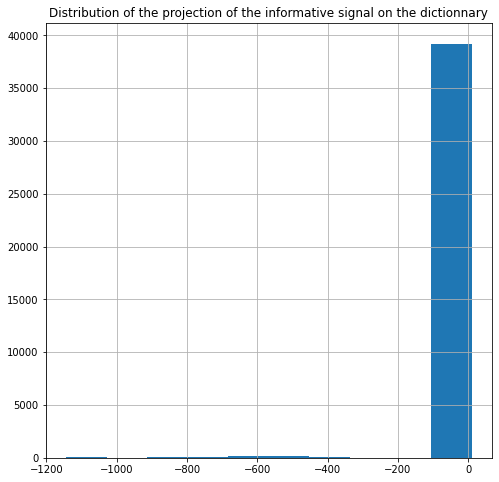

In [34]:
#Let us check is the distribution of the noise on the atoms is gaussian
signal=np.load('/content/signal.npy')
product = np.dot(DICO.T,signal)
plt.figure(figsize=(8,8))
plt.hist(product,density=False)
plt.title('Distribution of the projection of the informative signal on the dictionnary')
plt.grid()
plt.show()

#V. Reproduction of the report results: denoising performance of the algorithms (Long to run)

Importation of the noises used in the experiments

In [ ]:
mkdir Results #We create a directory for the experiments results. 

In [ ]:
!wget https://www.dropbox.com/s/osjvjezneu7kmc0/bluenoise.npy?dl=0 -O /content/bluenoise.npy
!wget https://www.dropbox.com/s/c9rhazggn05t2dr/browniannoise.npy?dl=0 -O /content/browniannoise.npy
!wget https://www.dropbox.com/s/uslaodckdb4uxfx/pinknoise.npy?dl=0 -O /content/pinknoise.npy
!wget https://www.dropbox.com/s/f8rfzuljrzb8qpn/purplenoise.npy?dl=0 -O /content/purplenoise.npy
!wget https://www.dropbox.com/s/mgcidmdpmvn3mjv/whitenoise.npy?dl=0 -O /content/whitenoise.npy

In [ ]:
white_noise=np.load('/content/whitenoise.npy')
blue_noise=np.load('/content/bluenoise.npy')
brown_noise=np.load('/content/browniannoise.npy')
pink_noise=np.load('/content/pinknoise.npy')
purple_noise=np.load('/content/purplenoise.npy')

noise_list={'white' : white_noise, 'blue' : blue_noise, 'brown' : brown_noise, 'pink' : pink_noise, 'purple' : purple_noise}
colors=['white','blue','brownian','pink','purple']
signal=np.load('/content/signal.npy')

Shrinkage results 

In [ ]:
wavelet = pywt.Wavelet('db4')
modes_threshold=['soft','hard']

for mode in modes_threshold :
    for color in colors :
        noise=np.load('/content/{}noise.npy'.format(color))
        signal_noisy=signal+noise
        filtered = wavelet_denoising(signal_noisy, wavelet=wavelet, level=1,mode_threshold=mode)
        np.save('/content/Results/'+'{}'.format(color)+'Shrink'+'{}'.format(mode)+'.npy', filtered)

Machting pursuit results 

In [ ]:
for color in colors :
    noise=np.load('/content/{}noise.npy'.format(color))
    signal_noisy=signal+noise
    params={"f" : signal_noisy, "D" : DICO, "target_d":180, "original":signal, "iter_max" :800}
    activationMP = matching_pursuit(**params)
    filtered = DICO @ activationMP
    np.save('/content/Results/{}MP.npy'.format(color),filtered)

SOMP results

In [ ]:
for color in colors :
    noise=np.load('/content/{}noise.npy'.format(color))
    signal_noisy=signal+noise
    sigmax = np.std(signal_noisy)**2
    sigma2 = 100/len(signal_noisy)
    c2 = sigmax/(sigmax+sigma2)
    params={"f" : signal_noisy,"D" : DICO,"c2":c2,"sigma2":sigma2,"target_d": 180, "original":signal,"iter_max" :800}

    activationSOMP = np.zeros(DICO.shape[1])
    J = 30
    for j in range(J):
      activationSOMP += random_orthogonal_matching_pursuit(**params)
    activationSOMP = activationSOMP/J

    filtered = DICO @ activationSOMP
    np.save('/content/Results/{}SOMP.npy'.format(color), filtered)

SMP results

In [ ]:
for color in colors :
    noise=np.load('/content/{}noise.npy'.format(color))
    signal_noisy=signal+noise
    params={"f" : signal_noisy,"D" : DICO,"subsize":DICO.shape[1]//30,"target_d":180,"original":signal,"iter_max" :800}
    activationSMP = np.zeros(DICO.shape[1])
    J = 30
    for j in range(J):
        params["iter"] = j
        activationSMP += random_matching_pursuit(**params)
    activationSMP = activationSMP/J
    filtered= DICO @ activationSMP 
    np.save('/content/Results/{}SMP.npy'.format(color), filtered)

#VI. Reproduction of the report results: Sensitivity with regards to the number of iterations (Long to run)

Useful function

In [ ]:
def p_opt(cond_chosen,N_signal,N_atoms) : #Function that calculates the value of $p$ by inversing the given formula.
  """
  Functon that, given a value of $\Lambda_{W}(\Phi, p)$ (cond_chosen), returns the p such that the forumula 
  $\Lambda_{W}(\Phi, p)=\frac{\sqrt{2}}{N} \sqrt{\left(1-\frac{2}{\pi}\right)} \operatorname{erfinv}\left((1-p)^{\frac{1}{M}}\right)$
  is verified. 
  """ 
  p_opt = 1-scipy.special.erf((cond_chosen*N_signal)/np.sqrt(2*(1-2/np.pi)))**(N_atoms)
  return p_opt

New definition of the bird function without the stopping condition

In [ ]:
def BIRD_bis(f,D,p,subsize,signal_clean,noisy_signal,iter_max):
    """
    BIRD algorithm (see https://arxiv.org/abs/1312.5444) without the stopping condition 
    Inputs:
      - f: signal to be denoised
      - D: dictionnary matrix of size (N_signal,N_atoms)
      - p: parameter in the stopping condition.
      - subsize: size of the subdictionnaries used at each iterations
      - iter_max: maximum number of iterations of the algorithm.
    Output:
      - a: Activation vector of size (N_atoms).
    """ 
    T1,T2=10,10
    DTW_List_signal=[]
    DTW_List_noisy=[]
    RMSE_signal=[]
    Res_rapports=[]
    List_Lambd_cond=[]
    N_signal,N_atoms = D.shape
    D = D/np.linalg.norm(D, axis=0) #The dictionnary is normalized. 
    a = np.zeros(N_atoms)
    r = f.copy() #Will contain the residual vector. 
    cond = np.sqrt(2)/N_signal*np.sqrt(1 - 2/np.pi)*erfinv((1-p)**(1/N_atoms)) #$\Lambda_{W}(\Phi, p)$ in the paper.
    residual_norm_cur = 0
    residual_norm_previous = 1
    index = list(np.arange(N_atoms))
    for t in range(iter_max) :
        RMSE_signal.append(rmse((D@a)[T1:-T2],signal_clean[T1:-T2]))
        DTW_List_signal.append(dtw((D @ a)[T1:-T2],signal_clean[T1:-T2]).distance)
        DTW_List_noisy.append(dtw((D @ a)[T1:-T2],noisy_signal[T1:-T2]).distance)
        selected_index = np.array(random.sample(index,subsize))
        subdic = D[:,selected_index] #Subdictionnary selected. 
        product = np.dot(subdic.T,r) #Scalar product between the current residual and the elements of the dictionnary. 
        i = np.argmax(np.abs(product))
        a[selected_index[i]] += product[i] #Update of the activation vector
        r = r -  product[i] * subdic[:,i] #Update of the residual.
        residual_norm_cur = np.linalg.norm(r)
        rapport = residual_norm_cur/residual_norm_previous
        Res_rapports.append(np.linalg.norm(rapport))
        lambda_cond = np.sqrt(1 - rapport**2) #$\lambda_{\Phi}(y)$
        List_Lambd_cond.append(lambda_cond)
        # if lambda_cond <= cond: #We do not use the stopping condition
        #     if t==0:
        #         continue
        #     else:
        #         break  
        residual_norm_previous = residual_norm_cur 
    del selected_index
    del r
    del product
    del subdic
    gc.collect()
    print(str(t) + str("-"),end = '')  
    return a , DTW_List_signal, DTW_List_noisy , Res_rapports , cond , List_Lambd_cond, RMSE_signal

In [ ]:
mkdir Results_parttwo

In [ ]:
cd Results_parttwo

In [ ]:
mkdir Purple

In [ ]:
mkdir Blue

In [ ]:
mkdir White

In [ ]:
mkdir Pink

In [ ]:
mkdir Brown

In [ ]:
cd /content/

Sensitivity analysis run

In [ ]:
colors=['Purple','Blue','White','Pink','Brown'] #1/f^{\alpha} for \alpha \in [-2,2]
alpha=-2
signal=np.load('/content/signal.npy')

for color in colors :

    N=100
    N_signal,N_atoms = DICO.shape
    Lists_DTWs_signal=[]
    Lists_DTWs_noisy=[]
    Lists_Lambd_cond=[]
    Lists_RMSE=[]

    Consts={}
    Consts['N_signal']=N_signal
    Consts['N_atoms']=N_atoms

    for i in range(N) :

        color_noise = color_noise_gen(370,.05,40,alpha,0.001)
        # color_noise=np.load('/content/{}noise.npy'.format(color.lower()))
        color_signal = signal+color_noise

        params={"f" : color_signal, "D" : DICO,"p":1e-10,"subsize":DICO.shape[1]//50,"signal_clean" : signal , "noisy_signal" : color_signal, "iter_max" :1000}

        a , DTW_List_signal, DTW_List_noisy , Res_rapports , cond , List_Lambd_cond, RMSE = BIRD_bis(**params)
        Lists_RMSE.append(RMSE)
        Lists_DTWs_signal.append(DTW_List_signal)
        Lists_DTWs_noisy.append(DTW_List_noisy)
        Lists_Lambd_cond.append(List_Lambd_cond)

    Consts['cond']=cond

    np.save('/content/Results_parttwo/{}/Consts.npy'.format(color),Consts)
    np.save('/content/Results_parttwo/{}/Lists_DTWs_signal.npy'.format(color),Lists_DTWs_signal)
    np.save('/content/Results_parttwo/{}/Lists_RMSE.npy'.format(color),Lists_RMSE)
    np.save('/content/Results_parttwo/{}/Lists_DTWs_noisy.npy'.format(color),Lists_DTWs_noisy)
    np.save('/content/Results_parttwo/{}/Lists_Lambd_cond.npy'.format(color),Lists_Lambd_cond)

    alpha+=1

In [ ]:
index_min_DTW=[]
index_min_DTW_noisy=[]
index_stop=[]
p_opt_list=[]
cond_opt_list=[]
N_signal=Consts['N_signal']
N_atoms=Consts['N_atoms']
cond=Consts['cond']
RMSE_opt=[]

for i in range(len(Lists_DTWs_signal)) :

    DTW_List_signal=Lists_DTWs_signal[i]
    DTW_List_noisy=Lists_DTWs_noisy[i]
    List_Lambd_cond=Lists_Lambd_cond[i]

    RMSE_list=Lists_RMSE[i]
    RMSE_opt.append((np.argmin(RMSE_list),min(RMSE_list)))
    cond_opt=List_Lambd_cond[np.argmin(DTW_List_signal)]
    cond_opt_list.append(cond_opt)
    p_opt_list.append(p_opt(cond_opt,N_signal,N_atoms))
    index_min_DTW.append((np.argmin(DTW_List_signal),np.min(DTW_List_signal)))
    index_min_DTW_noisy.append((np.argmin(DTW_List_noisy),np.min(DTW_List_noisy)))
    index_stop.append((np.where(List_Lambd_cond<=cond)[0][0],DTW_List_signal[np.where(List_Lambd_cond<=cond)[0][0]]))

In [ ]:
def gamma_cond(p) :
    cond = np.sqrt(2)/N_signal*np.sqrt(1 - 2/np.pi)*erfinv((1-p)**(1/N_atoms))
    return cond

In [ ]:
def index_stop_p(p,List_Lambd_cond=List_Lambd_cond) :
    cond=gamma_cond(p)
    if np.where(List_Lambd_cond<=cond)[0].shape[0] > 0 :
        index_stop=np.where(List_Lambd_cond<=cond)[0][0]
        return index_stop
    else :
        return len(List_Lambd_cond)-1

Results 

In [ ]:
colors=['Purple','Blue','White','Pink','Brown'] #1/f^{\alpha} for \alpha \in [-2,2]
means_min_DTW=[]
means_min_DTW_noisy=[]
means_index_stop=[]
Gap=[]

for color in colors : 

    Consts=np.load('/content/Results_parttwo/{}/Consts.npy'.format(color),allow_pickle=True)
    Lists_DTWs_signal=np.load('/content/Results_parttwo/{}/Lists_DTWs_signal.npy'.format(color),allow_pickle=True)
    Lists_RMSE=np.load('/content/Results_parttwo/{}/Lists_RMSE.npy'.format(color),allow_pickle=True)
    Lists_DTWs_noisy=np.load('/content/Results_parttwo/{}/Lists_DTWs_noisy.npy'.format(color),allow_pickle=True)
    Lists_Lambd_cond=np.load('/content/Results_parttwo/{}/Lists_Lambd_cond.npy'.format(color),allow_pickle=True)

    index_min_DTW=[]
    index_min_DTW_noisy=[]
    index_stop=[]
    p_opt_list=[]
    cond_opt_list=[]
    N_signal=Consts.item()['N_signal']
    N_atoms=Consts.item()['N_atoms']
    cond=Consts.item()['cond']
    RMSE_opt=[]

    for i in range(len(Lists_DTWs_signal)) :

        DTW_List_signal=Lists_DTWs_signal[i]
        DTW_List_noisy=Lists_DTWs_noisy[i]
        List_Lambd_cond=Lists_Lambd_cond[i]

        RMSE_list=Lists_RMSE[i]
        RMSE_opt.append((np.argmin(RMSE_list),min(RMSE_list)))
        cond_opt=List_Lambd_cond[np.argmin(DTW_List_signal)]
        cond_opt_list.append(cond_opt)
        p_opt_list.append(p_opt(cond_opt,N_signal,N_atoms))
        index_min_DTW.append((np.argmin(DTW_List_signal),np.min(DTW_List_signal)))
        index_min_DTW_noisy.append((np.argmin(DTW_List_noisy),np.min(DTW_List_noisy)))
        index_stop.append((np.where(List_Lambd_cond<=cond)[0][0],DTW_List_signal[np.where(List_Lambd_cond<=cond)[0][0]]))

    means_min_DTW.append(np.mean(firsts(index_min_DTW)))
    means_min_DTW_noisy.append(np.mean(firsts(index_min_DTW_noisy)))
    means_index_stop.append(np.mean(firsts(index_stop)))

plt.figure(figsize=(20,10))
plt.plot(means_min_DTW,label='index min DTW')
plt.plot(means_min_DTW_noisy,label='index min DTW with Noisy')
plt.plot(means_index_stop,label='min index stop with p=1e-10')
plt.xlabel('alpha (in 1/f^{\alpha})')
plt.ylabel('Mean index value (N=10 runs)')
plt.legend()
plt.grid()
plt.show()

#VII. Reproduction of the visualisation (fast to run, no need for the two precedent parts) - Denoising

In [35]:
mkdir project_results

In [36]:
!wget https://www.dropbox.com/s/7fclcyrnfge066y/project_results.zip?dl=0 -O /content/project_results.zip

--2022-03-23 19:44:00--  https://www.dropbox.com/s/7fclcyrnfge066y/project_results.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7fclcyrnfge066y/project_results.zip [following]
--2022-03-23 19:44:00--  https://www.dropbox.com/s/raw/7fclcyrnfge066y/project_results.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2aee465e1a7856287ea0dbaade.dl.dropboxusercontent.com/cd/0/inline/BiCGLgQhhcTw5GggA1Oc7i5QxFg5MrQhZOmB7iY_pGv_g87JntSGuOKWBIPOy6ZpzR6fMhr8ru0WKqqpN55LIhS3Va2lFoRX4-uAiTwjFolEhwsLf8RJpWJhrF9M5AJRuBYJCfNGj-8ytAC-ap0Q0t5VtKthuAPAxvPE8stWCq9LXg/file# [following]
--2022-03-23 19:44:00--  https://uc2aee465e1a7856287ea0dbaade.dl.dropboxusercontent.com/cd/0/inline/BiCGLgQhhcTw5GggA1Oc7i5QxFg5MrQhZOmB7iY_pG

In [ ]:
!unzip /content/project_results.zip -d /content/project_results

Importation of the noise realisations used in the report

In [39]:
!wget https://www.dropbox.com/s/osjvjezneu7kmc0/bluenoise.npy?dl=0 -O /content/bluenoise.npy
!wget https://www.dropbox.com/s/c9rhazggn05t2dr/browniannoise.npy?dl=0 -O /content/browniannoise.npy
!wget https://www.dropbox.com/s/uslaodckdb4uxfx/pinknoise.npy?dl=0 -O /content/pinknoise.npy
!wget https://www.dropbox.com/s/f8rfzuljrzb8qpn/purplenoise.npy?dl=0 -O /content/purplenoise.npy
!wget https://www.dropbox.com/s/mgcidmdpmvn3mjv/whitenoise.npy?dl=0 -O /content/whitenoise.npy

--2022-03-23 19:45:56--  https://www.dropbox.com/s/osjvjezneu7kmc0/bluenoise.npy?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/osjvjezneu7kmc0/bluenoise.npy [following]
--2022-03-23 19:45:56--  https://www.dropbox.com/s/raw/osjvjezneu7kmc0/bluenoise.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6ec05fa925fff22a12be923719.dl.dropboxusercontent.com/cd/0/inline/BiAGSPr_U_xgc5CQHqOhjeHGrLSCUDdEdckRsD48Jzyjc2JMeMoS34a196poRAM9z8HLO4vraHUXyM87we5V1CsI2rRXF5KOdVN4qVEUFZKxIjvzG2E759JLnMGZtgf3O-pa9eOhosXv-0jwcPqvtPgUiquYz9iqXGajMmI55YkJ0w/file# [following]
--2022-03-23 19:45:56--  https://uc6ec05fa925fff22a12be923719.dl.dropboxusercontent.com/cd/0/inline/BiAGSPr_U_xgc5CQHqOhjeHGrLSCUDdEdckRsD48Jzyjc2JMeMoS34a196po

DTW distances before denoising 

In [40]:
colors=['purple','blue','white','pink','brownian'] #1/f^{\alpha} for \alpha \in [-2,2]

T=20 #To not take account of edge effects
signal=np.load('/content/signal.npy')[T:-T]
num_algo=0
num_color=0
DTW_distances=np.zeros((1,len(colors)))
num_color=0

for color in colors :
    noise=np.load('/content/{}noise.npy'.format(color))[T:-T]
    noisy_signal=signal+noise
    DTW_distances[0,num_color]=round(dtw(noisy_signal,signal).distance,2)
    num_color+=1

print(DTW_distances)

[[322.23 353.09 325.01 311.07 155.42]]


array([[158.52, 182.45, 190.17, 144.95, 159.92],
       [206.15, 273.24, 222.04, 323.83, 310.33],
       [322.23, 353.09, 325.01, 311.07, 157.42],
       [196.25, 203.89, 226.91, 198.25, 197.52],
       [120.96, 123.32, 110.61, 120.19, 121.08],
       [255.66, 260.58, 266.79, 242.15, 128.79]])

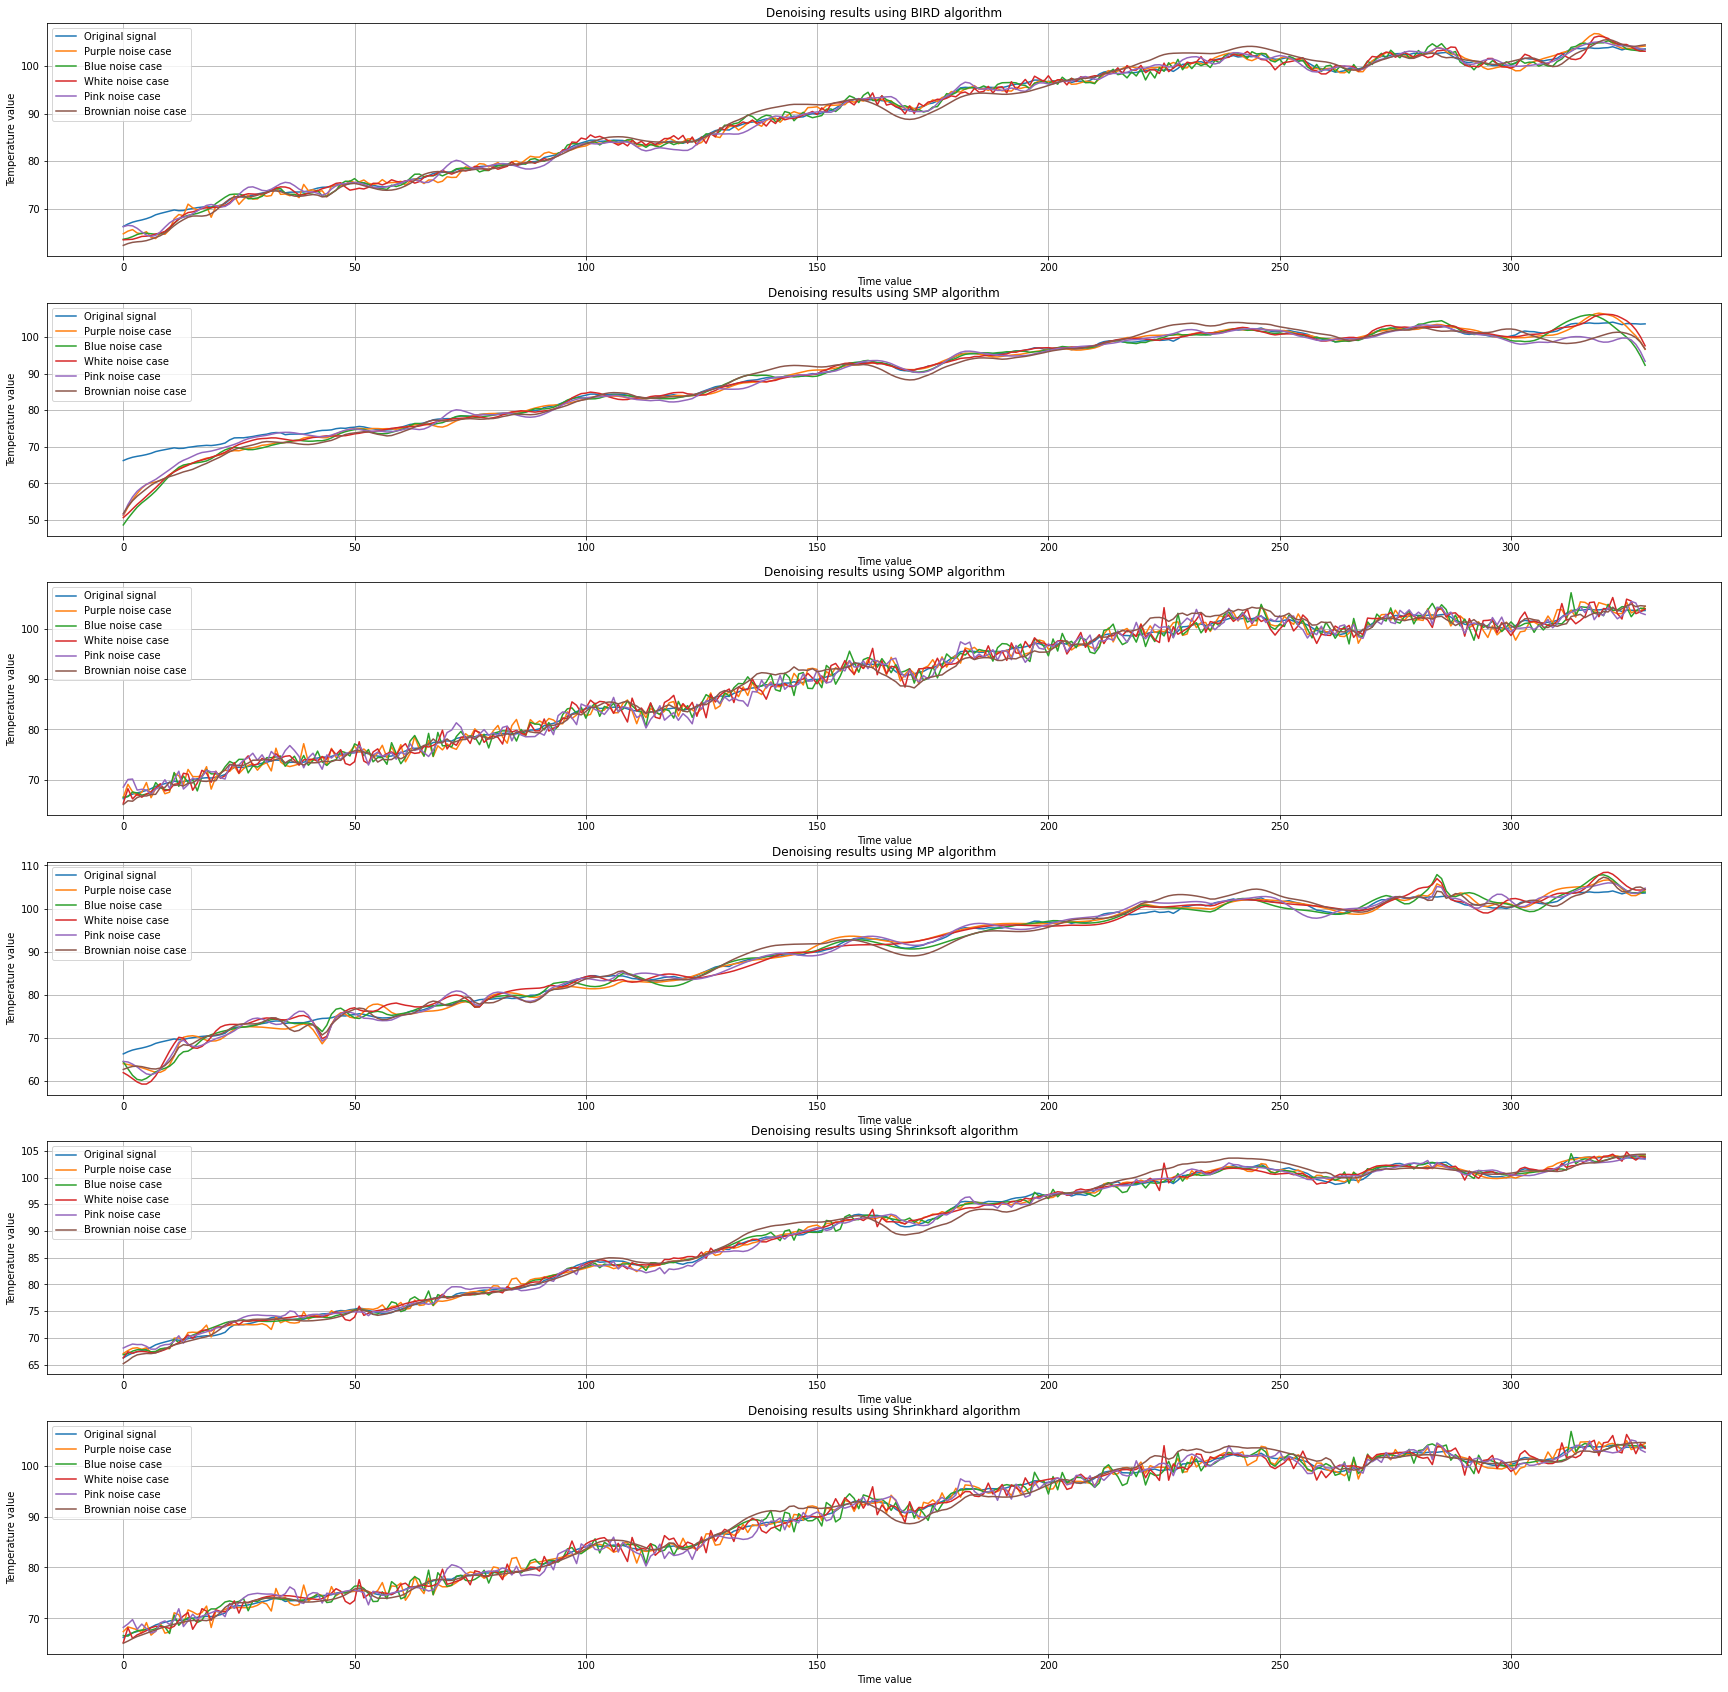

In [41]:
colors=['purple','blue','white','pink','brownian'] #1/f^{\alpha} for \alpha \in [-2,2]
Algos=['BIRD','SMP','SOMP','MP','Shrinksoft','Shrinkhard']

fig,ax=plt.subplots(len(Algos),1,figsize=(30,30))
T=20
signal=np.load('/content/signal.npy')[T:-T]
num_algo=0
num_color=0
DTW_matrix=np.zeros((len(Algos),len(colors)))

for algo in Algos :
    ax[num_algo].plot(signal,label='Original signal')
    ax[num_algo].set_title('Denoising results using {} algorithm'.format(algo))
    num_color=0
    for color in colors :
        filename=color+algo+'.npy'
        denoised_signal=np.load('/content/project_results/{}'.format(filename))[T:-T]
        ax[num_algo].plot(denoised_signal,label='{} noise case'.format(color[0].upper()+color[1:]))
        DTW_matrix[num_algo,num_color]=round(dtw(denoised_signal,signal).distance,2)
        num_color+=1
    ax[num_algo].legend()
    ax[num_algo].grid()
    ax[num_algo].set_xlabel('Time value')
    ax[num_algo].set_ylabel('Temperature value')
    num_algo+=1

DTW_matrix

#VIII. Reproduction of the original results of the report (fast to run) - Sensitivity analysis 

Useful function 

In [42]:
def p_opt(cond_chosen,N_signal,N_atoms) : #Function that calculates the value of $p$ by inversing the given formula.
  """
  Functon that, given a value of $\Lambda_{W}(\Phi, p)$ (cond_chosen), returns the p such that the forumula 
  $\Lambda_{W}(\Phi, p)=\frac{\sqrt{2}}{N} \sqrt{\left(1-\frac{2}{\pi}\right)} \operatorname{erfinv}\left((1-p)^{\frac{1}{M}}\right)$
  is verified. 
  """ 
  p_opt = 1-scipy.special.erf((cond_chosen*N_signal)/np.sqrt(2*(1-2/np.pi)))**(N_atoms)
  return p_opt

Folder for sensitivity analysis 

In [43]:
cd /content/

/content


In [44]:
mkdir original_results_parttwo

Importation of the zip file containing the results given in the report

In [45]:
!wget https://www.dropbox.com/s/qcwky32q1krpiy5/Original_results.zip?dl=0 -O /content/original_results_parttwo/Original_results.zip

--2022-03-23 19:46:20--  https://www.dropbox.com/s/qcwky32q1krpiy5/Original_results.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/qcwky32q1krpiy5/Original_results.zip [following]
--2022-03-23 19:46:20--  https://www.dropbox.com/s/raw/qcwky32q1krpiy5/Original_results.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc37579988b613b81ccfb3b5538.dl.dropboxusercontent.com/cd/0/inline/BiAJkk8xaoAZNdz18xMea0Qfk-ah9_aER89n0vAqO3CewnZ6hrn_ruwipLWxVpTMbCM7-x8Ni8Bcjb4ahn1VYJZArZfFK55ahni3sT0ocf_QwRMSxXE5rjZazoxyHe-uDJbAlUhOBJGVedz7etIVTT2L1jM_TlxoGWU5Kw5XuGoUAg/file# [following]
--2022-03-23 19:46:20--  https://ucc37579988b613b81ccfb3b5538.dl.dropboxusercontent.com/cd/0/inline/BiAJkk8xaoAZNdz18xMea0Qfk-ah9_aER89n0vA

Extraction of the zip file

In [46]:
!unzip /content/original_results_parttwo/Original_results.zip -d /content/original_results_parttwo/

Archive:  /content/original_results_parttwo/Original_results.zip
   creating: /content/original_results_parttwo/Blue/
  inflating: /content/original_results_parttwo/Blue/Lists_DTWs_noisy.npy  
  inflating: /content/original_results_parttwo/__MACOSX/Blue/._Lists_DTWs_noisy.npy  
  inflating: /content/original_results_parttwo/Blue/Lists_Lambd_cond.npy  
  inflating: /content/original_results_parttwo/__MACOSX/Blue/._Lists_Lambd_cond.npy  
  inflating: /content/original_results_parttwo/Blue/Lists_RMSE.npy  
  inflating: /content/original_results_parttwo/__MACOSX/Blue/._Lists_RMSE.npy  
  inflating: /content/original_results_parttwo/Blue/Consts.npy  
  inflating: /content/original_results_parttwo/__MACOSX/Blue/._Consts.npy  
  inflating: /content/original_results_parttwo/Blue/Lists_DTWs_signal.npy  
  inflating: /content/original_results_parttwo/__MACOSX/Blue/._Lists_DTWs_signal.npy  
   creating: /content/original_results_parttwo/Brown/
  inflating: /content/original_results_parttwo/Brown/

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 7 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 7 missing from current font.
  font.set_text(s, 0, flags=flags)


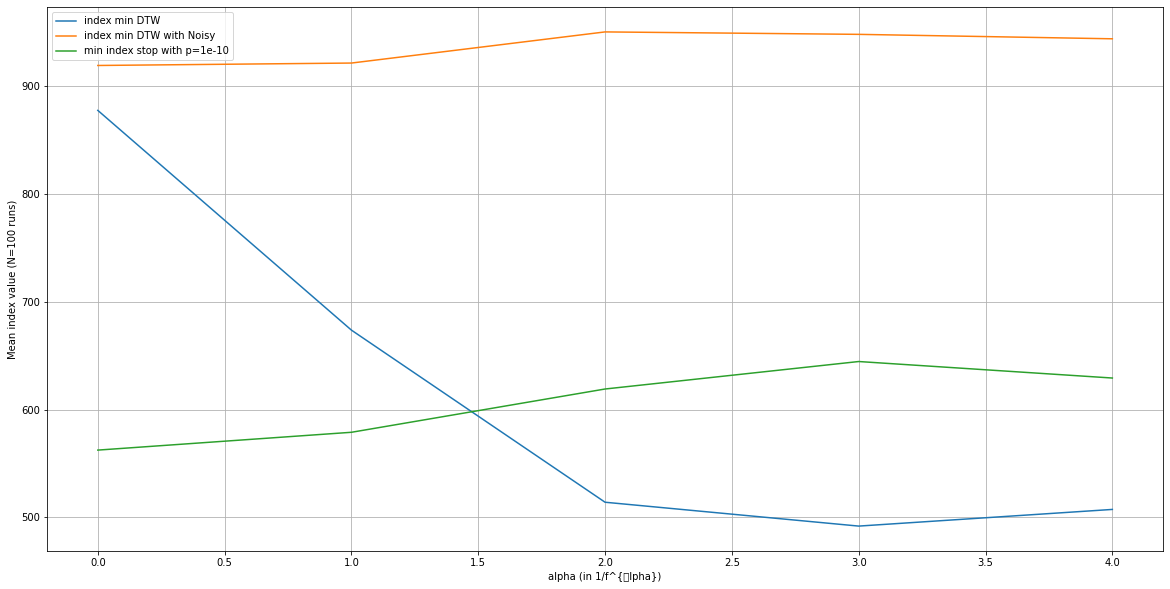

In [47]:
colors=['Purple','Blue','White','Pink','Brown'] #1/f^{\alpha} for \alpha \in [-2,2]
means_min_DTW=[]
means_min_DTW_noisy=[]
means_index_stop=[]
stds_min_DTW=[]
stds_min_DTW_noisy=[]
stds_index_stop=[]
Gap=[]

for color in colors : 

    Consts=np.load('/content/original_results_parttwo/{}/Consts.npy'.format(color),allow_pickle=True)
    Lists_DTWs_signal=np.load('/content/original_results_parttwo/{}/Lists_DTWs_signal.npy'.format(color),allow_pickle=True)
    Lists_RMSE=np.load('/content/original_results_parttwo/{}/Lists_RMSE.npy'.format(color),allow_pickle=True)
    Lists_DTWs_noisy=np.load('/content/original_results_parttwo/{}/Lists_DTWs_noisy.npy'.format(color),allow_pickle=True)
    Lists_Lambd_cond=np.load('/content/original_results_parttwo/{}/Lists_Lambd_cond.npy'.format(color),allow_pickle=True)

    index_min_DTW=[]
    index_min_DTW_noisy=[]
    index_stop=[]
    p_opt_list=[]
    cond_opt_list=[]
    N_signal=Consts.item()['N_signal']
    N_atoms=Consts.item()['N_atoms']
    cond=Consts.item()['cond']
    RMSE_opt=[]

    for i in range(len(Lists_DTWs_signal)) :

        DTW_List_signal=Lists_DTWs_signal[i]
        DTW_List_noisy=Lists_DTWs_noisy[i]
        List_Lambd_cond=Lists_Lambd_cond[i]

        RMSE_list=Lists_RMSE[i]
        RMSE_opt.append((np.argmin(RMSE_list),min(RMSE_list)))
        cond_opt=List_Lambd_cond[np.argmin(DTW_List_signal)]
        cond_opt_list.append(cond_opt)
        p_opt_list.append(p_opt(cond_opt,N_signal,N_atoms))
        index_min_DTW.append((np.argmin(DTW_List_signal),np.min(DTW_List_signal)))
        index_min_DTW_noisy.append((np.argmin(DTW_List_noisy),np.min(DTW_List_noisy)))
        index_stop.append((np.where(List_Lambd_cond<=cond)[0][0],DTW_List_signal[np.where(List_Lambd_cond<=cond)[0][0]]))

    means_min_DTW.append(np.mean(firsts(index_min_DTW)))
    means_min_DTW_noisy.append(np.mean(firsts(index_min_DTW_noisy)))
    means_index_stop.append(np.mean(firsts(index_stop)))

    stds_min_DTW.append(np.std(firsts(index_min_DTW)))
    stds_min_DTW_noisy.append(np.std(firsts(index_min_DTW_noisy)))
    stds_index_stop.append(np.std(firsts(index_stop)))

plt.figure(figsize=(20,10))
plt.plot(means_min_DTW,label='index min DTW')
plt.plot(means_min_DTW_noisy,label='index min DTW with Noisy')
plt.plot(means_index_stop,label='min index stop with p=1e-10')
plt.xlabel('alpha (in 1/f^{\alpha})')
plt.ylabel('Mean index value (N=100 runs)')
plt.legend()
plt.grid()
plt.show()